# Task 2 - Descriptive Analytics

<i>The operator of the two sites is interested in the operational performance
and statistics of their charging hubs. As the company’s data scientist, your task is to facilitate this.
Proceed as follows:</i>
    
## (a) Temporal Patterns and Seasonality:
<i>Demonstrate how the number of charging events varies during
the day, the week, and between seasons. What patterns can you observe and how do you explain
them?</i>

In [1]:
# All imports are listed and executed here:
import numpy as np
import pandas as pd
from datetime import datetime
import pytz
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from ipywidgets import *
import ipympl
import plotly.express as px # important! version 5.18 conda install -c plotly plotly
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
# Import dataset and convert timestamp columns to datetime object:
df_charging = pd.DataFrame(pd.read_csv("../datasets/df_charging_sessions_with_weather.csv"))
df_charging['connectionTime'] = pd.to_datetime(df_charging['connectionTime'], utc=True).dt.tz_convert('America/Los_Angeles')
df_charging['disconnectTime'] = pd.to_datetime(df_charging['disconnectTime'], utc=True).dt.tz_convert('America/Los_Angeles')
df_charging['doneChargingTime'] = pd.to_datetime(df_charging['doneChargingTime'], utc=True).dt.tz_convert('America/Los_Angeles')

In [3]:
import ast
input_list = []
for index,row in df_charging.iterrows():
    cell = row['userInputs']
    if cell == '[]':
        as_frame = pd.DataFrame(data=None)
        input_list.append(as_frame)
        continue
    to_dic = ast.literal_eval(cell[1:-1])
    if type(to_dic) == tuple:
        as_frame = pd.DataFrame(data=None)
    else:
        as_frame = pd.DataFrame.from_dict(to_dic,orient='index')
        as_frame.loc['id',:] = row['id']
    input_list.append(as_frame)
    
df_userinput = pd.concat(input_list,axis=1)
df_userinput = df_userinput.transpose()
df_charging = pd.merge(left=df_charging,right=df_userinput,left_on='id',right_on='id',suffixes=('','_y'),how='left')

In [4]:
# Add hour, weekday, month and total charging time columns:
df_charging['Hour'] =df_charging['connectionTime'].dt.hour
df_charging['HourDis'] =df_charging['disconnectTime'].dt.hour
df_charging['Weekday'] =df_charging['connectionTime'].dt.weekday
df_charging['Month'] =df_charging['connectionTime'].dt.month
df_charging['duration'] = df_charging['disconnectTime'] - df_charging['connectionTime']
df_charging['duration'] = df_charging['duration'].map(lambda x: x.seconds/3600)
df_charging['kwh per Hour delivered'] = df_charging['kWhDelivered']/df_charging['duration'] 
df_charging['duration charging'] = df_charging['doneChargingTime'] - df_charging['connectionTime']
df_charging['duration charging'] = df_charging['duration charging'].map(lambda x: x.seconds/3600)
df_charging['duration parking'] = df_charging['disconnectTime'] - df_charging['doneChargingTime']
df_charging['duration parking'] = df_charging['duration parking'].map(lambda x: x.seconds/3600)


Below we plotted the total charging sessions per hour, per weekday and per month. For the following charts and analysis we combined Site 1 & 2 because it didn't had a distorting effect on the patterns we observed. In Part C we will go further into the analysis of the differences between Site 1 & 2
- For the <b>hourly</b> pattern: In the morning a lot of people starting their charging sessions (blue line) and in the afternoon most of the sessions end (orange line). This perfectly fits the pattern of going to work, plug in your car to the charging station at the office and disconnect your car when leaving the office
 <br> 
- For the <b>weekday</b> pattern: The behaviour fits to the pattern seen in the hourly chart. Most charging sessions occur during workdays, when people commute to the office while on the weekends there is noticeably less traffic.
 <br> 
- For the <b>monthly/quartely</b> pattern: There is no real explainable behaviour why there is such a strong drop off in April. The lower charging sessions in December could be explained by less travel to the office during the holiday season.  <br> 
  <br> 
  More on the strange pattern in April follows below.


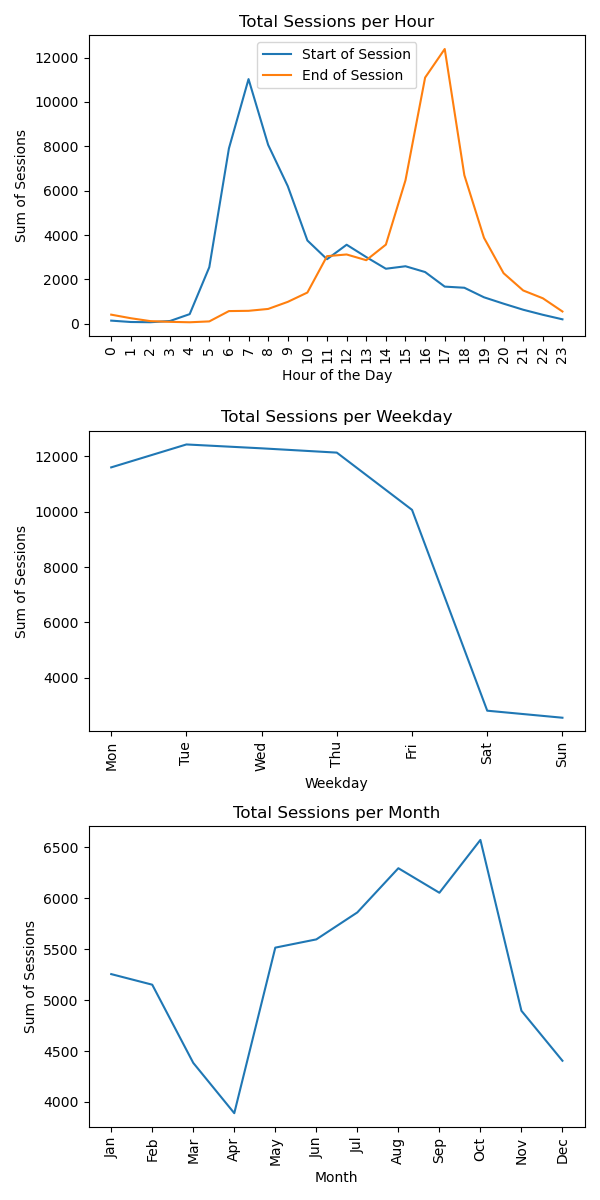

In [5]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(6, 12))

df_charging_gr_hr = df_charging.groupby(['Hour'])['sessionID'].count()
df_charging_gr_hr_dis = df_charging.groupby(['HourDis'])['sessionID'].count()
df_charging_gr_wd = df_charging.groupby(['Weekday'])['sessionID'].count()
df_charging_gr_mt = df_charging.groupby(['Month'])['sessionID'].count()

# Plot each DataFrame on separate subplot
axes[0] = df_charging_gr_hr.plot(ax=axes[0], label='Start of Session')
df_charging_gr_hr_dis.plot(x='A', y='B', label='End of Session', ax=axes[0])
axes[0].set_xlabel ('Hour of the Day')
axes[0].set_ylabel ('Sum of Sessions')
axes[0].set_xticks(np.arange(24)) 
axes[0].set_title('Total Sessions per Hour')
axes[0].tick_params(axis='x', rotation=90)
axes[0].legend()

df_charging_gr_wd.plot(ax=axes[1], title='Weekday Pattern')
axes[1].set_xlabel('Weekday')
axes[1].set_ylabel('Sum of Sessions')
axes[1].set_xticks(np.arange(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']) 
axes[1].set_title('Total Sessions per Weekday')
axes[1].tick_params(axis='x', rotation=90)

df_charging_gr_mt.plot(ax=axes[2], title='Monthly Pattern')
axes[2].set_xlabel('Month')
axes[2].set_ylabel('Sum of Sessions')
axes[2].set_xticks(np.arange(1,13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']) 
axes[2].set_title('Total Sessions per Month')
axes[2].tick_params(axis='x', rotation=90)

fig.tight_layout()

plt.savefig('../plots/total_sessions_seasonal_pattern.png', dpi = 600)
plt.show()



More on the monthly pattern we observed. If we plot the number of sessions by month and year we see the clear impact of the covid 19 pandemic. The number of charging session falls of steeply in March 2020, because people stayed at home and didn't commute to work. Also there are no charging sessions in the data between the 5th of August 2020 and the 17th of November 2020, but that is not so easy to see with the eyes in the chart. 

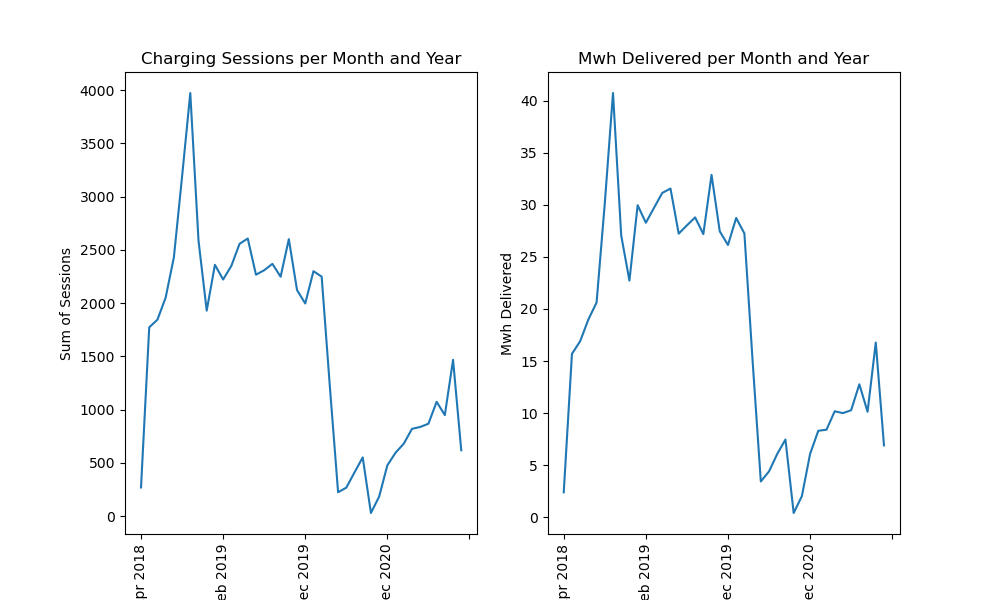

In [6]:
dic_int_to_mon = {1: "Jan", 2: "Feb", 3: "Mar", 4: "Apr", 5: "May", 6: "Jun", 7: "Jul", 8: "Aug", 9: "Sep", 10: "Oct", 11: "Nov", 12: "Dec" }
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))

df_charging['Year'] =df_charging['connectionTime'].dt.year
df_charge_gr_yr = df_charging.groupby(['Year','Month']) ['sessionID'].count().reset_index()
df_charge_gr_yr['DateStr'] =  df_charge_gr_yr['Month'].map(dic_int_to_mon)
df_charge_gr_yr['DateStr'] = df_charge_gr_yr['DateStr'] + ' ' + df_charge_gr_yr['Year'].astype(str)
df_charge_gr_yr.plot(ax=axes[0],y='sessionID',x='DateStr',rot=90,legend=False)
axes[0].set_ylabel('Sum of Sessions')
axes[0].set_xlabel(None)
axes[0].set_title('Charging Sessions per Month and Year')

df_charge_gr_kwh = df_charging.groupby(['Year','Month']) ['kWhDelivered'].sum().reset_index()
df_charge_gr_kwh['kWhDelivered'] = df_charge_gr_kwh['kWhDelivered']/1000
df_charge_gr_kwh['DateStr'] =  df_charge_gr_kwh['Month'].map(dic_int_to_mon)
df_charge_gr_kwh['DateStr'] = df_charge_gr_kwh['DateStr'] + ' ' + df_charge_gr_yr['Year'].astype(str)
df_charge_gr_kwh.plot(ax=axes[1],y='kWhDelivered',x='DateStr',rot=90,legend=False)
axes[1].set_ylabel('Mwh Delivered')
axes[1].set_xlabel(None)
axes[1].set_title('Mwh Delivered per Month and Year')

plt.savefig('../plots/whole_time_series_plot.png', dpi = 600)
plt.show()


In [7]:
df_missing = df_charging[(df_charging['connectionTime']>'2020-08-04') & (df_charging['connectionTime']<'2020-11-17') ].copy()
if len(df_missing) == 0:
    print('There is no Data between the 5th of August 2020 and the 17th of November 2020')

There is no Data between the 5th of August 2020 and the 17th of November 2020


## (b) Key Performance Indicators (KPIs):
<i>Define at least (!) three KPIs that you would include in a
dashboard for the hub operator. These KPIs must provide an immediate overview of the current
hub operation and how it is doing in terms of utilization or other business-related aspects. Briefly
explain the rationale behind selecting each KPI, explain why you have chosen it and, where
needed, provide references. Calculate hourly values for the selected KPIs and visualize them over
time. Which trends do you observe? How do you explain them?</i>

<b>% Utilization of Site:</b>  
This KPI presents how many of the charging station per site are blocked by a car. This shows us the degree of utilization and if the station is over- or underutilized. We choose this metric because it shows if the site has the right size or should be scaled up or down. 
We calculated the 7 day rolling average for the visualization, to smooth the representation.
We see the utilization droped after the covid pandemic and hasn't fully recovered since then.
Also Site 1 has a way higher utilization on average and had a very constant utilization pre covid.
Site 2 on the other hand has a high variance in utilization and never really recovered from the covid shock.
Additionally the aforementioned missing data from August to November 2020 is visible.


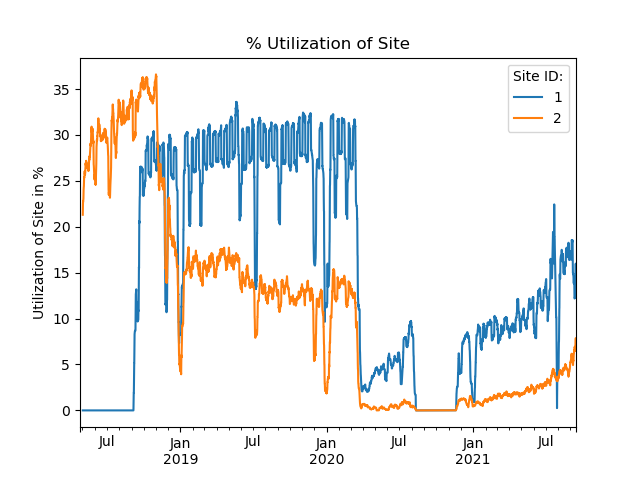

In [8]:
date_range_charging = pd.date_range(start='2018-04-25', end='2021-09-15',freq='H',tz='UTC')   
site_demand = np.zeros(( len(date_range_charging),2 ))  

for i,time in enumerate(date_range_charging):

    demand_session = df_charging[( df_charging['connectionTime']<time ) & (df_charging['disconnectTime']>time)]
    demand_session_gr = demand_session.groupby('siteID')['sessionID'].count()
    try:
        site_1 = demand_session_gr.loc[1]
    except:
        site_1 = 0
    try:
        site_2 = demand_session_gr.loc[2]
    except:
        site_2 = 0
    site_demand[i,:] = [site_1,site_2]

df_sitecount = df_charging.groupby('siteID')['stationID'].nunique()
df_utilization = pd.DataFrame(data=site_demand,index=date_range_charging,columns=['1','2'])
df_utilization['1'] = (df_utilization['1']/df_sitecount.loc[1])*100
df_utilization['2'] = (df_utilization['2']/df_sitecount.loc[2])*100
df_utilization_avg = df_utilization.rolling(168).mean()

df_utilization_avg.plot()
plt.legend(loc = 'upper right', title = 'Site ID:')
plt.ylabel('Utilization of Site in %')
plt.title('% Utilization of Site')
plt.show()



To get the right interpretation of the chart above, we need to check if the number of stations is stable as assumed in the formula. We asked ChatGPT to visualize:

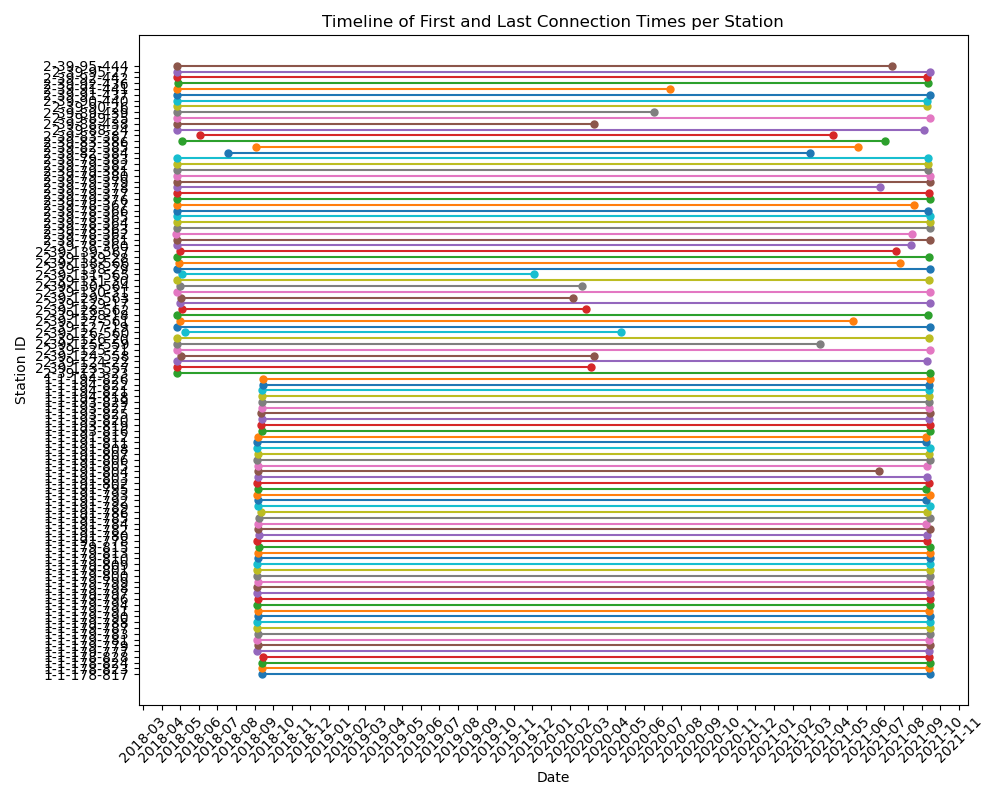

In [9]:
# Generated with ChatGPT, but edited.

charging_sessions_df = pd.DataFrame(pd.read_csv("../datasets/df_charging_sessions_with_weather.csv"))


# Convert connectionTime to datetime
charging_sessions_df['connectionTime'] = pd.to_datetime(charging_sessions_df['connectionTime'], errors='coerce', utc=True)

charging_sessions_df.sort_values(by=['siteID', 'stationID'])

# Group by stationID and find the first and last connectionTime for each station
station_connection_times = charging_sessions_df.groupby('stationID')['connectionTime'].agg(['min', 'max']).reset_index()

# Select a subset of stations for plotting
subset_station_connection_times = station_connection_times

# Plotting
fig, ax = plt.subplots(figsize=(10, 8))

# For each station, plot the min and max connection times
for index, row in subset_station_connection_times.iterrows():
    ax.plot([row['min'], row['max']], [index, index], marker='o', linestyle='-', markersize=5, label=row['stationID'])

# Formatting the plot
ax.set_yticks(range(len(subset_station_connection_times)))
ax.set_yticklabels(subset_station_connection_times['stationID'])
ax.xaxis_date()  # Ensure the x-axis is formatted as dates
ax.xaxis.set_major_locator(mdates.MonthLocator())  # Set major ticks to months
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format dates as Year-Month
plt.xticks(rotation=45)  # Rotate date labels for better readability
plt.xlabel('Date')
plt.ylabel('Station ID')
plt.title('Timeline of First and Last Connection Times per Station')
plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels

plt.show()

The results shown that the number of stations on side 1 is stable, but on side 2 more stations are never connected in the future. So the rise of utilization at the end of site 2 is not 100% correct.

<b>Avg Kwh per charging cycle per Site:</b>  
This KPI presents how many Kwh were delivered on avg per hour in a charging cycle per site (Formula: Mean( kWhDelivered/Duration charging) ) . This shows us if the cars charging used the full charging capacity possible or maybe parked for a long time while only a low amount of energy was charged. We choose this metric because it shows how effective and lucrative the charging session was for the site operator. 
We calculated the 7 day rolling average for the visualization, to smooth the representation.
We see some extrem outlier, but on average Site 2 charged more kwh per hour charging before 2020. This makes sense as Site 2 has a shorter charging cycle and therefore a higher throughput (this analysis follows in section c). But since then the pattern has inverted but catched up in the last few month.

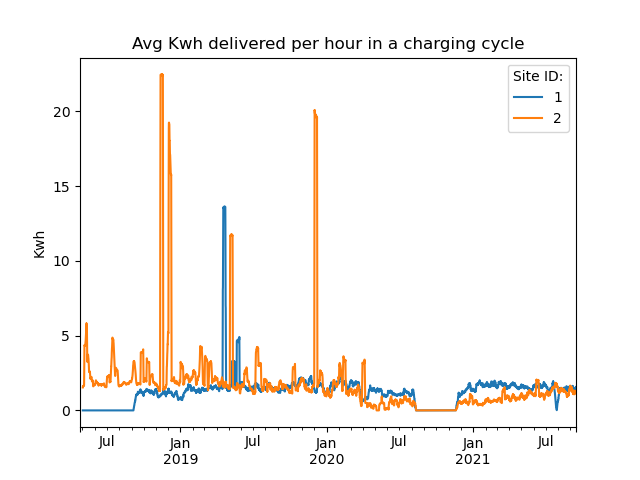

In [10]:
site_kwhdelivered = np.zeros(( len(date_range_charging),2 ))  

for i,time in enumerate(date_range_charging):

    demand_session = df_charging[( df_charging['connectionTime']<time ) & (df_charging['disconnectTime']>time)]
    demand_session_gr = demand_session.groupby('siteID')['kwh per Hour delivered'].mean()
    try:
        site_1 = demand_session_gr.loc[1]
    except:
        site_1 = 0
    try:
        site_2 = demand_session_gr.loc[2]
    except:
        site_2 = 0
    site_kwhdelivered[i,:] = [site_1,site_2]

df_kwhdelivered = pd.DataFrame(data=site_kwhdelivered,index=date_range_charging,columns=['1','2'])
df_kwhdelivered_avg = df_kwhdelivered.rolling(168).mean()

df_kwhdelivered_avg.plot()
plt.legend(loc = 'upper right', title = 'Site ID:')
plt.ylabel('Kwh')
plt.title('Avg Kwh delivered per hour in a charging cycle')
plt.show()


<b>KPI: charging and parking time</b><br>
If in the future the utilization would be remarkably high, increasing parking time costs could be interesting.

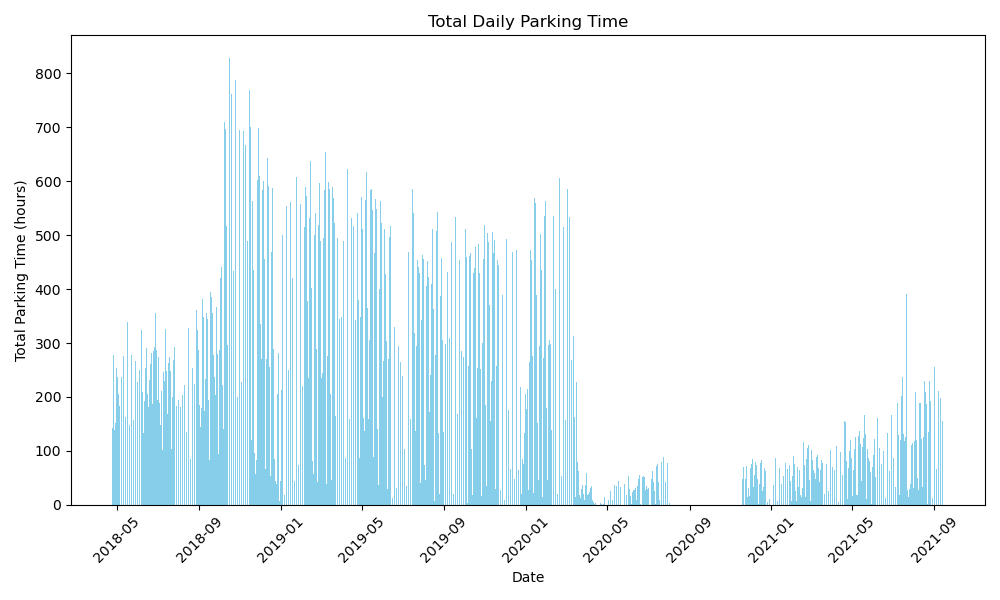

In [11]:
from datetime import datetime, timedelta

df_kpi_parking = pd.DataFrame(pd.read_csv("../datasets/df_charging_sessions_with_weather.csv"))

# Convert the 'disconnectTime' and 'doneChargingTime' columns to datetime
df_kpi_parking['disconnectTime'] = pd.to_datetime(df_kpi_parking['disconnectTime'], utc=True)
df_kpi_parking['doneChargingTime'] = pd.to_datetime(df_kpi_parking['doneChargingTime'], utc=True)

# Calculate the parkingTime for each row
# TODO: DO we really need that? This is parking time / charging
df_kpi_parking['parkingTime'] = df_kpi_parking['disconnectTime'] - df_kpi_parking['doneChargingTime']

# Create a function to calculate parking time for each day
def calculate_daily_parking_time(row):
    start = row['doneChargingTime']
    end = row['disconnectTime']
    parking_time = end - start

    # Initialize a dictionary to store parking time for each day
    daily_parking_time = {}

    while start.date() < end.date():
        end_of_day = datetime(start.year, start.month, start.day, 23, 59, 59, tzinfo=start.tzinfo)
        daily_parking_time[start.date()] = (end_of_day - start).total_seconds()
        start = end_of_day + timedelta(seconds=1)

    # Add parking time for the last day
    if end.date() not in daily_parking_time:
        daily_parking_time[end.date()] = parking_time.total_seconds()
    else:
        daily_parking_time[end.date()] += (end - start).total_seconds()

    return daily_parking_time

# Apply the function to each row
df_kpi_parking['dailyParkingTime'] = df_kpi_parking.apply(calculate_daily_parking_time, axis=1)

# Sum up the parking time for each individual day
total_parking_time_per_day = {}
for daily_times in df_kpi_parking['dailyParkingTime']:
    for date, time in daily_times.items():
        if date in total_parking_time_per_day:
            total_parking_time_per_day[date] += time
        else:
            total_parking_time_per_day[date] = time

total_parking_time_per_day_sorted = dict(sorted(total_parking_time_per_day.items()))

# Convert total parking time from seconds to hours for better readability
total_parking_time_per_day_hours = {date: time / 3600 for date, time in total_parking_time_per_day_sorted.items()}

dates = list(total_parking_time_per_day_hours.keys())
parking_times = list(total_parking_time_per_day_hours.values())

plt.figure(figsize=(10, 6))
plt.bar(dates, parking_times, color='skyblue')
plt.xlabel('Date')
plt.ylabel('Total Parking Time (hours)')
plt.title('Total Daily Parking Time')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

To get a better visulizsation of the data and to also see the charging and parking in one view, we created a tool:<br>
<br>
<b>First you need to run the hole notebook, then just this code below, to get the interative dropdowns</b>

In [12]:
%matplotlib widget

df_kpi_daily_parking = pd.DataFrame(pd.read_csv("../datasets/df_charging_sessions_with_weather.csv"))

# Convert columns to datetime
df_kpi_daily_parking['connectionTime'] = pd.to_datetime(df_kpi_daily_parking['connectionTime'], utc=True)
df_kpi_daily_parking['doneChargingTime'] = pd.to_datetime(df_kpi_daily_parking['doneChargingTime'], utc=True)
df_kpi_daily_parking['disconnectTime'] = pd.to_datetime(df_kpi_daily_parking['disconnectTime'], utc=True)

def load_from_widget( 
        start_day = pd.date_range(min(total_parking_time_per_day_sorted), max(total_parking_time_per_day_sorted)),
        end_day = pd.date_range(min(total_parking_time_per_day_sorted), max(total_parking_time_per_day_sorted))[1:]
    ):

    filter_start_day = pd.to_datetime(start_day, utc=True);
    filter_end_day = pd.to_datetime(end_day, utc=True);

    filter = ( \
        ( ( filter_start_day >= df_kpi_daily_parking['connectionTime'] ) & ( filter_start_day <= df_kpi_daily_parking['disconnectTime'] ) ) | \
        ( ( filter_end_day >= df_kpi_daily_parking['connectionTime'] ) & ( filter_end_day <= df_kpi_daily_parking['disconnectTime'] ) ) | \
        ( ( df_kpi_daily_parking['connectionTime'] <= filter_end_day ) & ( df_kpi_daily_parking['disconnectTime'] >= filter_start_day ) )
    )
    
    # TODO: I am not sure if this is good code. Maybe there is a better way of the for loop.
    
    rows = []
    
    for index, row in df_kpi_daily_parking[filter].iterrows():
        # Adding 'charging' type
        rows.append({
            'id': row['id'],
            'startTime': row['connectionTime'],
            'endTime': row['doneChargingTime'],
            'siteID': row['siteID'],
            'spaceID': row['spaceID'],
            'stationID': row['stationID'],
            'type': 'charging'
        })
    
        # Adding 'parking' type
        rows.append({
            'id': row['id'],
            'startTime': row['doneChargingTime'],
            'endTime': row['disconnectTime'],
            'siteID': row['siteID'],
            'spaceID': row['spaceID'],
            'stationID': row['stationID'],
            'type': 'parking'
        })
    
    # Creating the new DataFrame from the list of dictionaries
    df_kpi_daily_parking_show = pd.DataFrame(rows)
    
    df_kpi_daily_parking_show["startTime"] = pd.to_datetime(df_kpi_daily_parking_show["startTime"])
    df_kpi_daily_parking_show["endTime"] = pd.to_datetime(df_kpi_daily_parking_show["endTime"])
    
    fig = px.timeline(df_kpi_daily_parking_show, x_start = "startTime", x_end = "endTime", y = "spaceID", color="type")
    
    fig.update_yaxes(autorange = "reversed") 
    fig.show()

# Call the ipywidgets interact function
interact(load_from_widget);


interactive(children=(Dropdown(description='start_day', options=(Timestamp('2018-04-25 00:00:00'), Timestamp('…

<b>Visulisation Addon for the hup operator.</b><br>
<i>We created an interactive dashboard to visulize: Hourly kWh delivered per Station per Day</i>

In [13]:
from ipywidgets import interact
df = pd.read_csv("../datasets/df_charging_sessions_with_weather.csv")

We compute a new table with for each hour, count of entries for each station, and kWh delivered for each station.

In [14]:
df['doneChargingTime'] = pd.to_datetime(df["doneChargingTime"], utc=True)
df.set_index('doneChargingTime', inplace=True)
df_sessions = df.groupby('stationID').resample('H').size().reset_index(name='session_count')
df_power = df.groupby('stationID').resample('H')['kWhDelivered'].sum().reset_index(name='total_power')
df_hourly = pd.merge(df_sessions, df_power, on=['doneChargingTime', 'stationID'])
df_hourly.head()

,stationID,doneChargingTime,session_count,total_power
0,1-1-178-817,2018-09-13 22:00:00+00:00,1,13.056
1,1-1-178-817,2018-09-13 23:00:00+00:00,0,0.000
2,1-1-178-817,2018-09-14 00:00:00+00:00,0,0.000
3,1-1-178-817,2018-09-14 01:00:00+00:00,0,0.000
4,1-1-178-817,2018-09-14 02:00:00+00:00,0,0.000


We use a mask to only examine values from the *df_hourly* dataframe from the last week of the data. In practice, one would use the data from the most recent week for this KPI.

In [15]:
print(df_hourly["doneChargingTime"].max())

2021-09-14 14:00:00+00:00


In [16]:
start_date = "2021-09-05 14:00"
end_date = "2021-09-14 14:00"
mask = (df_hourly['doneChargingTime'] > start_date) & (df_hourly['doneChargingTime'] <= end_date)
week_data = df_hourly.loc[mask]

Now, let us create an interactive plot to visualize the *hourly kWh delivered per station per day*. For that, we use the *ipywidgets* library, which lets us select a specific day and station from a dropdown menu and updates the graph based on the selection. For additional comparison, we also plot the average kWh delivered for all stations as a red line.

interactive(children=(Dropdown(description='stationID', options=('1-1-178-817', '1-1-178-823', '1-1-178-824', …

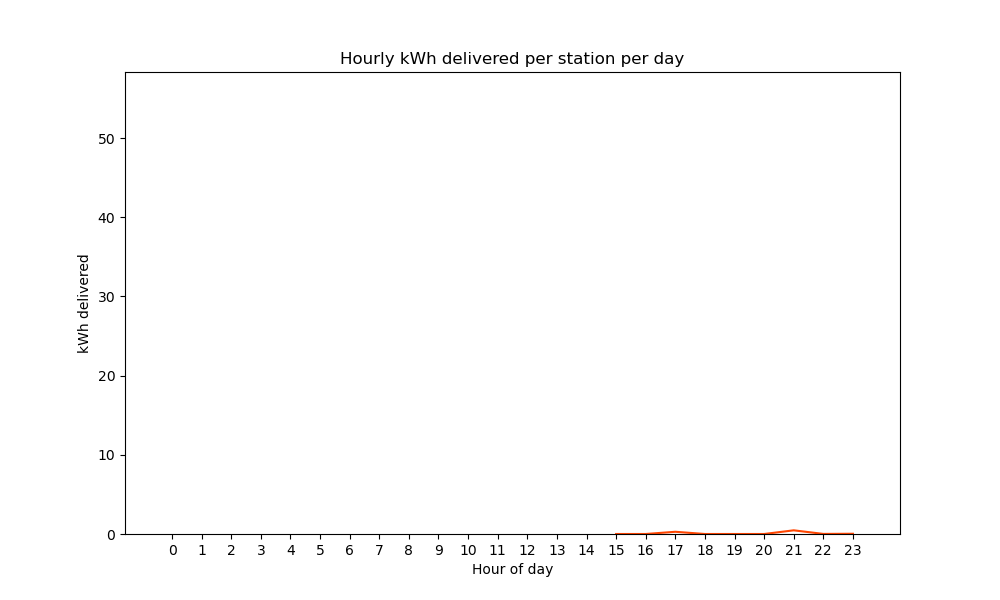

In [24]:
%matplotlib widget
    
# Convert 'doneChargingTime' to datetime and extract the hour and day from that
week_data.loc[:, 'doneChargingTime'] = pd.to_datetime(week_data['doneChargingTime'])
week_data.loc[:, 'hour'] = week_data['doneChargingTime'].dt.hour
week_data.loc[:, 'day'] = week_data['doneChargingTime'].dt.date
    
# Group by 'day', 'hour' and 'stationID' and calculate the mean
a = week_data.groupby(['day', 'hour','stationID'])['total_power'].mean().reset_index()
a = pd.pivot_table(a, values='total_power',index=['day', 'hour'],columns='stationID')
a = a.fillna(0)
    
# Define x values, create the figure, define b used to plot the mean of kWh delivered for all stations for the selected day
x = a.index.get_level_values('hour').unique()
plt.figure(figsize=(10,6))
b = []

# Define the update function that updates graph based on the selected stationID and day
def update(stationID = list(a.columns.values), day = list(a.index.get_level_values('day').unique())):
    plt.clf()
    plt.xticks(np.arange(0, 24, 1))
    y = a.xs(day, level='day')[stationID]
    if len(y) < 24:
        y = np.append(y, [0]*(24-len(y)))  # Append zeros if y has less than 24 values
    b = a.xs(day, level='day').mean(axis=1) #Calculate the average of the power for all stations to plot as the red line
    plt.bar(x, y, color='skyblue')
    plt.plot(b, color = "orangered")
    plt.xlabel('Hour of day')
    plt.ylabel('kWh delivered')
    plt.ylim(0, week_data['total_power'].max())
    plt.title('Hourly kWh delivered per station per day')
    plt.savefig('../plots/hourly_kwh_delivered_per_station_per_day.png', dpi = 600)

# Call the ipywidgets interact function
interact(update);

*Note: To see the interactive graph, the above cells need to be executed.*

Therefore, we now have the KPI *hourly kWh delivered per station*, in a nice interactive graphic that could be displayed in a dashboard to:

- Examine the power supply of individual stations for different days
- Identify problematic stations or days in detail
- Compare individual stations to the added average for all stations (red line)
- Instantly download the plot for a chosen station to share it

## (c) Site Characteristics: 
<i>The hub operator provided you with the data set, but has seemed to forget
which site was supplying which data... Can you find out which of the two sites is the public one?
Try to combine data understanding from previous descriptive analytics with domain knowledge
(business understanding) of how private vs. public charging hubs might differ in operation. Explain
your line of thought!</i>

<b>Analysis:</b>  
To distingusih both sites and decide which one is public and which one is private (company site). Indicators could be differences in usage during weekdays as we assume that there are less charging events during weekends on private hubs and vice versa on weekdays. Also duration could reveal insights as we expect the public site to have rather shorter charging cycles than the private business site. Also it could be that a vast amount of private location users work a classic 9-5. This means that a lot of charging sessions could last from 8 to 10 hours. In contrast to this, a lot of public charging sessions would probably last somewhere about 0 to 4 hours.

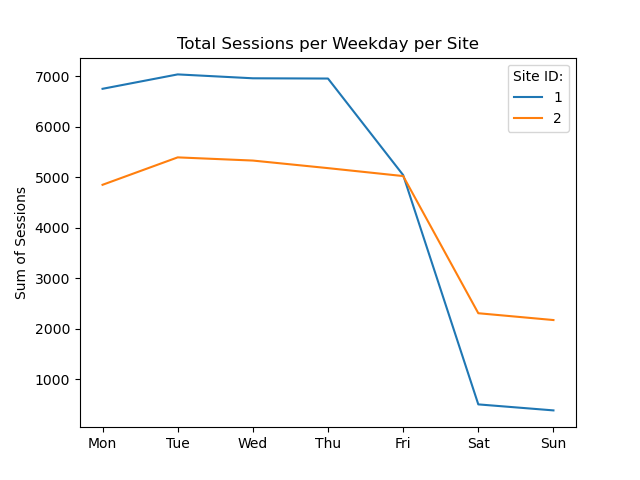

In [18]:
# Plot total sessions per weekday per site and save as PNG file:
df_charging_gr_wd = df_charging.groupby(['Weekday','siteID'])['sessionID'].count().reset_index()
df_charging_gr_wd = pd.pivot_table(df_charging_gr_wd,values='sessionID',index='Weekday',columns='siteID')
df_charging_gr_wd.plot()
plt.xlabel(None)
plt.legend(title = 'Site ID:')
plt.ylabel('Sum of Sessions')
plt.xticks(np.arange(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']) 
plt.title('Total Sessions per Weekday per Site')
plt.savefig('../plots/total_sessions_per_weekday_per_site.png', dpi = 600)
plt.show()

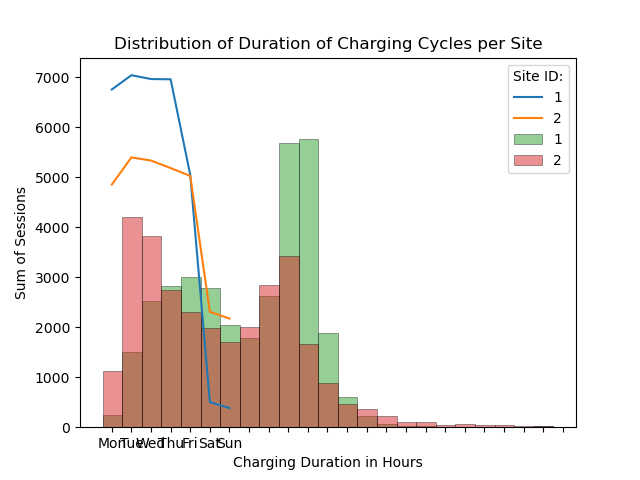

In [19]:
# Plot distribution of duration of charging cycles per site and save as PNG file:
plt.hist(df_charging[df_charging['siteID'] == 1]['duration'], bins = np.arange(min(df_charging['duration']),
    max(df_charging['duration']), 1) - 0.5,alpha = 0.5, label = '1', edgecolor='black', linewidth = 0.5)
plt.hist(df_charging[df_charging['siteID'] == 2]['duration'], bins = np.arange(min(df_charging['duration']),
    max(df_charging['duration']), ) - 0.5,alpha = 0.5, label = '2', edgecolor='black', linewidth = 0.5)
plt.legend(loc = 'upper right', title = 'Site ID:')
plt.xlabel("Charging Duration in Hours")
plt.xticks(np.arange(0, 24, 1))
plt.ylabel('Sum of Sessions')
plt.title('Distribution of Duration of Charging Cycles per Site')
plt.savefig('../plots/distribution_of_duration_of_charging_cycles_per_site.png', dpi = 600)
plt.show()

<b>Conclusion:</b>  
For Site 1 we see a bigger difference between the number of charging sessions on workdays and weekends while on Site 2 the pattern is less distinct. Also Site 1 has longer charging cycles leading us to the conclussion that people stay longer on this, site fitting our arguments mentioned above. Therefore we conclude that <b>Site 1 is private and Site 2 is public</b>  . 

## (d) Further Data Analysis for the report:

Distribution of Utilization used in 2b), we see that station 2 is 10% of the time often more than 80% utilized

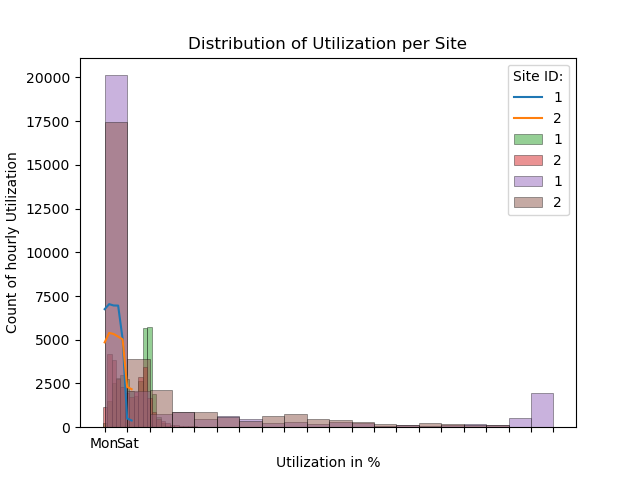

In [20]:
plt.hist(df_utilization['1'], bins=np.arange(0, 105 , 5),alpha = 0.5, label = '1', edgecolor='black', linewidth = 0.5)
plt.hist(df_utilization['2'], bins=np.arange(0, 105 , 5),alpha = 0.5, label = '2', edgecolor='black', linewidth = 0.5)
plt.legend(loc = 'upper right', title = 'Site ID:')
plt.xticks(np.arange(0, 105 , 5))
plt.xlabel("Utilization in %")
plt.ylabel('Count of hourly Utilization')
plt.title('Distribution of Utilization per Site')
plt.savefig('../plots/distribution_of_utilization_per_site.png', dpi = 600)
plt.show()

Parking time of a session, when charging was already finished. We look at absolute time and not percentage because it is more relevant in our case how long in total a station is blocked. We see that at Station 1 the users on average park longer, but Site 2 has bigger outliers.

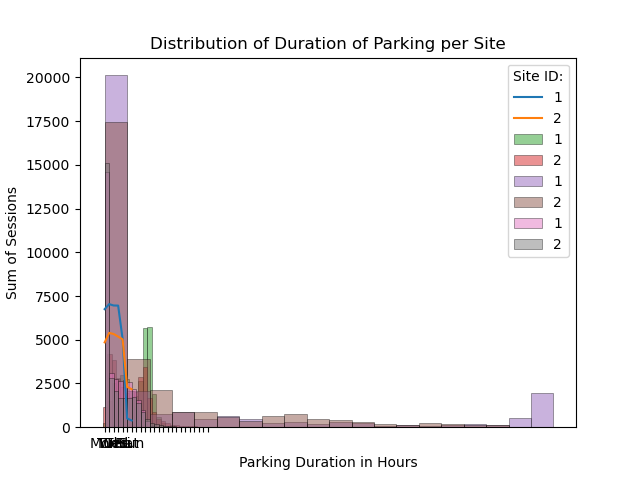

In [21]:
plt.hist(df_charging[df_charging['siteID'] == 1]['duration parking'], bins = np.arange(0, 24, 1),alpha = 0.5, label = '1', edgecolor='black', linewidth = 0.5)
plt.hist(df_charging[df_charging['siteID'] == 2]['duration parking'], bins = np.arange(0, 24, 1),alpha = 0.5, label = '2', edgecolor='black', linewidth = 0.5)
plt.legend(loc = 'upper right', title = 'Site ID:')
plt.xlabel("Parking Duration in Hours")
plt.xticks(np.arange(0, 24, 1))
plt.ylabel('Sum of Sessions')
plt.title('Distribution of Duration of Parking per Site')
plt.savefig('../plots/distribution_of_duration_of_parking_per_site.png', dpi = 600)
plt.show()

How often has a user identified by the UserID visited one of the sites. We see at Site 1 are more recurring users

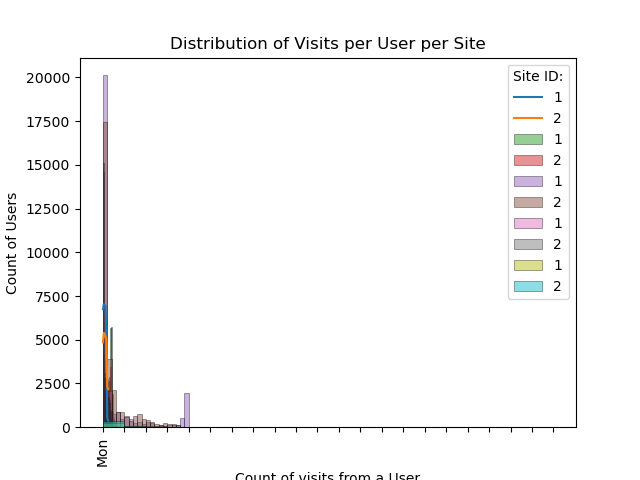

In [22]:
df_charging_user_gr = df_charging.groupby(['userID','siteID'])['sessionID'].count().reset_index()
plt.hist(df_charging_user_gr[df_charging_user_gr['siteID'] == 1]['sessionID'], bins = np.arange(0,550,25),alpha = 0.5, label = '1', edgecolor='black', linewidth = 0.5)
plt.hist(df_charging_user_gr[df_charging_user_gr['siteID'] == 2]['sessionID'], bins = np.arange(0,550,25),alpha = 0.5, label = '2', edgecolor='black', linewidth = 0.5)
plt.legend(loc = 'upper right', title = 'Site ID:')
plt.xlabel("Count of visits from a User")
plt.xticks(np.arange(0,550,25),rotation=90)
plt.ylabel('Count of Users')
plt.title('Distribution of Visits per User per Site')
plt.savefig('../plots/distribution_of_user_visits.png', dpi = 600)
plt.show()

On the left we show how many Charging Sessions happened and how many had a user entry. We see at the beginning of the data sample the difference was very big but narrowed down to the end. On the right we show how big the difference between the requested kwh and the charged kwh was. Given that an electic vehicle has on avg a 70kwh battery* and the median difference between requested and deliveres is at 6, that means 10% of the battery capacity was not used. If that was due to a slower charging mechanism at the more the battery is charged or due to other factors can't be solved. But the operator should try to minimize the gap

*https://ev-database.org/de/cheatsheet/useable-battery-capacity-electric-car

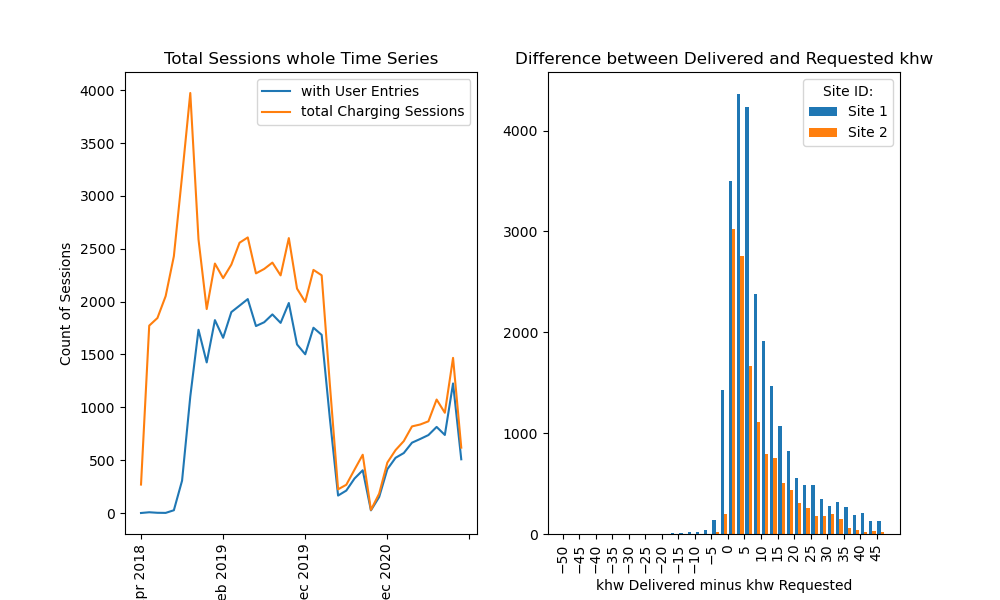

In [23]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))

dic_int_to_mon = {1: "Jan", 2: "Feb", 3: "Mar", 4: "Apr", 5: "May", 6: "Jun", 7: "Jul", 8: "Aug", 9: "Sep", 10: "Oct", 11: "Nov", 12: "Dec" }

df_charging_gr_input = df_charging.groupby(['Year','Month']).agg({ 'kWhRequested':'count','sessionID':'count'}).reset_index()
df_charging_gr_input['DateStr'] =  df_charging_gr_input['Month'].map(dic_int_to_mon)
df_charging_gr_input['DateStr'] = df_charging_gr_input['DateStr'] + ' ' + df_charging_gr_input['Year'].astype(str)

# Plot each DataFrame on separate subplot
axes[0] = df_charging_gr_input.plot(ax=axes[0],x='DateStr', y=['kWhRequested','sessionID'],label=['with User Entries','total Charging Sessions'])
axes[0].set_ylabel ('Count of Sessions')
axes[0].set_title('Total Sessions whole Time Series')
axes[0].tick_params(axis='x', rotation=90)
axes[0].legend()

df_user_input = df_charging[df_charging['kWhRequested']>0]
df_user_input['Charging Diff'] = df_user_input['kWhRequested']- df_user_input['kWhDelivered']
axes[1].hist([df_user_input[df_user_input['siteID'] == 1]['Charging Diff'],df_user_input[df_user_input['siteID'] == 2]['Charging Diff']],bins = np.arange(-50,50,2.5),label=['Site 1','Site 2'])
axes[1].set_xticks(np.arange(-50,50,5))
axes[1].set_title('Difference between Delivered and Requested khw')
axes[1].set_xlabel ('khw Delivered minus khw Requested')
axes[1].tick_params(axis='x', rotation=90)
axes[1].legend(loc = 'upper right', title = 'Site ID:')
plt.show()